<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Base/AI_HW6_uplift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Задание по Uplift-моделированию </h1>

<h2>Введение</h2>

Перед вами типичная задача, возникающая при работе с моделями кампейнинга в банке: заказчик запустил несколько пилотов по взаимодействию с клиентами с помощью разных каналов: push в мобильном приложении, sms, баннеры в мобильном приложении и реклама в других приложениях экосистемы. Заказчик хотел бы понимать, какой канал взаимодействия с клиентом наиболее эффективен для каждого клиента из клиентской базы. Кампании планируются и запускаются в ежемесячном режиме. Иными словами, заказчик хотел бы в идеале ежемесячно получать список клиентов, которым необходимо отправить коммуникацию с указанием канала и прироста вероятности покупки в случае, если клиенту отправят коммуникацию по сравнению с тем случаем, когда клиенту коммуникацию не отправят.

<b>Таким образом: </b>
1.	У нас есть база клиентов (клиенты, имеющие id в банке). По данной базе осуществляется рассылка тех или иных стимулирующих коммуникаций по различным продуктам, каналам (например SMS, Push, баннеры в мобильном приложении и т.д.) и сегментам клиентов
2.	Признаковое описание клиента состоит из различных агрегатов действий клиента за месяц или его объективных характеристик: например, средняя сумма средств на депозитах за месяц, среднее число кликов клиента в день за месяц в разделе "инвестиции" в мобильном приложении или возраст клиента
3.	При формировании обучающей/тестовой выборки допускается, что один и тот же клиент за разные месяцы — это разные объекты. То есть допускается, что клиент в феврале и клиент в марте — это разные клиенты (то есть мы можем оперировать с ними как с разными сущностями).
4.	Агрегаты действий клиента за месяц появляются примерно 10 числа следующего месяца. То есть, например, агрегаты за декабрь появляются 10 января. В свою очередь списки клиентов, которым необходимо осуществить рассылку должны быть сформированы ориентировочно 20 числа предыдущего месяца. Таким образом, <b> модель должна быть обучена делать предсказания с лагом в два месяца </b>, то есть должна делать предсказание на март по клиентским агрегатам за январь. Обязательно учтите это при обучении модели (в противном случае можно получить лик таргета, так как часто величину, которую мы предсказываем уже есть в клиентских агрегатах, но смещенная на два месяца).


## Оценивание задания:

Всего за задание можно получить 50 первичных баллов, которые затем переводятся в 10-балльную шкалу делением не 5.

Скачаем архив с данными по ссылке и разархивируем.

In [1]:
!pip install gdown -q

In [2]:
import gdown

url = 'https://drive.google.com/uc?id=19nKGaxm3RwHxh2UWPo537_-MDx21AkHO'
output = 'Data.zip'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=19nKGaxm3RwHxh2UWPo537_-MDx21AkHO
From (redirected): https://drive.google.com/uc?id=19nKGaxm3RwHxh2UWPo537_-MDx21AkHO&confirm=t&uuid=19d91fab-b8f7-448f-97b2-8d3542cc1d76
To: c:\Users\DARYA\Desktop\Stud\AI\Data.zip
100%|██████████| 289M/289M [04:26<00:00, 1.09MB/s] 


'Data.zip'

In [3]:
import zipfile

with zipfile.ZipFile('Data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

<h2>Описание данных</h2>

Перед вами несколько наборов данных, на основе которых вам будет необходимо обучить Uplift модели, сделать прогноз на нужный месяц и решить, кому из клиентов отправлять коммуникацию, а кому коммуникацию отправлять не следует.

<h3>Features </h3> Признаки клиентов, клиентские агрегаты, которые описывают поведение клиентов <br>

1. user_id - id клиента
2. report_dt - месяц, на который актуальны признаки
3. city - город, в котором живет клиент
4. age - возраст клиента
5. x1 – x9 - числовые признаки клиента, характеризующие поведение клиента

Первичный ключ таблицы - user_id + report_dt

<h3> Contracts </h3> Таблица с покупками продуктов.

1. contract_id - id покупки
2. user_id - id пользователя, который совершил покупку
3. product_id - id продукта, который был куплен
4. contract_ts – дата момента, когда была совершена покупка

Первичный ключ - contract_id


<h3> Campaings </h3> Кампании, которые проводились (под кампанией мы понимаем рассылку sms, push и т.д).

1. campaing_id - id кампании, первичный ключ таблицы
2. product_id - продукт, по которому проводилась кампания (считаем, что продукты не конкурируют друг с другом)
3. channel - канал, в котором проводилась кампания


<h3> People_in_campaings </h3> Люди, которые принимали участие в кампаниях.

1. campaing_id - id кампании
2. user_id - id пользователя, который попал в кампанию
3. флаг целевой (1) и контрольной (0) группы (целевая группа - это те, кто получил коммуникацию, а контрольная - те, кто нет)
4. delivery_ts - timestamp, когда клиенту фактически была доставлена коммуникация (для контрольной группы nan, подумайте почему)

Первичный ключ данной таблицы - user_id + campaing_id


<h3> Contracts </h3> Таблица с покупками продуктов

1. contract_id - id покупки
2. user_id - id пользователя, который совершил покупку
3. product_id - id продукта, который был куплен
4. contract_ts – дата момента, когда была совершена покупка

Первичный ключ - contract_id


<h1> Постановка задачи </h1> В ноябре 2024 проводилось несколько кампаний по продукту с id 0001 (фактически клиенту рассылалось одно и тоже сообщение, но в разных каналах). Вам необходимо по данным кампаниям построить модель, которая будет определять лучший канал коммуникации каждого клиента и определить, кому из клиентов в марте 2025 отправить какую коммуникацию, а кому коммуникацию вообще отправлять не следует.
Ответ нужно представить в следующем виде (report_dt – дата фичей):

<table>
  <thead>
    <tr>
      <th>user_id</th>
      <th>report_dt</th>
      <th>channel</th>
      <th>uplift</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>10045</td>
      <td>2025-01-31</td>
      <td>banner</td>
      <td>0.07</td>
    </tr>
    <tr>
      <td>10046</td>
      <td>2025-01-31</td>
      <td>no_comm</td>
      <td>0.00</td>
    </tr>
    <tr>
      <td>10047</td>
      <td>2025-01-31</td>
      <td>sms</td>
      <td>0.23</td>
    </tr>
    <tr>
      <td>10048</td>
      <td>2025-01-31</td>
      <td>push</td>
      <td>0.19</td>
    </tr>
  </tbody>
</table>

<h1> Декомпозиция задачи </h1>

<h2> 1.	Сбор и анализ таргета (18 баллов)</h2>

Прежде всего, вам необходимо собрать целевое событие, которое вы собираетесь прогнозировать. В данном случае целевое событие - это покупка продукта 0001 пользователем, участвовавшем в кампании. Обратите внимание, что не все пользователи получают коммуникацию одновременно (delivery_ts в таблице People_in_campaings). Согласно правилу, согласованному с заказчиком, <b> человек из целевой группы купил продукт после коммуникации - это значит, что он купил его в течение 2х недель после получения сообщения, а человек из контрольной - в течение 3х недель с момента старта кампании (старт кампании - начало месяца). </b> То есть для определенной кампании, для каждого клиента, попавшего в кампанию, вам надо будет найти его покупки данного продукта, а потом основываяся на данном правиле превратить покупки в 0 или 1. <br> На выходе у вас должен появиться таблица с целевым действием для каждого канала (колонки client_id, report_dt,  target), где таргет - это бинарная переменная (0 или 1). Колонка report_dt вам нужна как техническая колонка для дальнейших джоинов.<br><br>

Проведите анализ полученных данных (до присоединения клиентских агрегатов). Какие проблемы и сложности в данных вы обнаружили? Что с ними можно сделать? Какая из кампаний наиболее эффективная? Подготовьте выводы по полученным инсайтам.


**Комментарий по заданиям и оцениванию:**

* Вы должны самостоятельно сделать join нескольких таблиц, самостоятельно собрать целевое действие

* Представлены 4 различных канала, за таргет по каждому из каналов можно получить **максимум 2 балла**:
    * 1 балл за то, что просчитано целевое действие для целевой группы (покупка в
течение одной-двух недель с момента получения коммуникации)
    * 1 балл за то, что просчитано целевое действие для контрольной группы (покупка в течение двух-трех недель с момента старта кампании) и сделана таблица в требуемом формате

* Обратите внимание, что не во всех кампаниях содержатся корректные данные для проведения моделирования, и вам необходимо провести анализ данных и в случае выявленных некорректностей - описать их, и не проводить моделирование для "сломанной" кампании  
    * За данный анализ можно получить **8 баллов**

* Вы должны оценить эффективность кампаний по uplift (cреднее значение таргета в целевой минус среднее значение таргета в контрольной группе)
    * За данный анализ можно получить **2 балла**

In [100]:
import pandas as pd
from psi import calculate_psi

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (train_test_split)
from sklearn.linear_model import LogisticRegression

from causalml.dataset import make_uplift_classification
from causalml.inference.tree import UpliftRandomForestClassifier

import optuna

from catboost import CatBoostClassifier

from sklift.models import (SoloModel,
                           ClassTransformation)
from sklift.metrics import (uplift_at_k,
                            uplift_auc_score,
                            qini_auc_score)
from sklift.viz import plot_qini_curve, plot_uplift_curve

import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
features = pd.read_csv('Data/AGGS_FINAL.csv', sep=',', index_col=0)
contracts = pd.read_csv('Data/CONTRACTS_FINAL.csv', sep=',', index_col=0)
campaings = pd.read_csv('Data/CAMPAINGS.csv', sep=',', index_col=0)
people_in_campaings = pd.read_csv('Data/PEOPLE_IN_CAMPAINGS_FINAL.csv', sep=',', index_col=0)

In [6]:
people_in_campaings['campaing'] = people_in_campaings.campaing_id.apply(lambda x: campaings[campaings.campaing_id == x].channel.values[0])
contracts['contract_date'] = pd.to_datetime(contracts['contract_date'], errors='ignore')

C:\Users\DARYA\AppData\Local\Temp\ipykernel_7616\2062831344.py:2: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  contracts['contract_date'] = pd.to_datetime(contracts['contract_date'], errors='ignore')


In [7]:
features['report_dt'] = pd.to_datetime(features['report_dt'], errors='coerce')
features = features[features['report_dt'] < pd.to_datetime('2025-02-01', format='%Y-%m-%d')].sort_values(by='report_dt', ascending=False).drop_duplicates(subset='user_id', keep='first') #для дальнейшего присоединения данных юзеров за январь

In [8]:
#соединяем таблицы
join_table = contracts[['user_id', 'contract_date']].copy()
join_table = join_table.merge(people_in_campaings[['user_id', 't_flag', 'delivery_date', 'campaing']], left_on='user_id', right_on='user_id')
join_table = join_table.merge(features[['report_dt', 'user_id']], left_on='user_id', right_on='user_id')

In [9]:
#расчет целевого значения
join_table['delivery_date'] = pd.to_datetime(join_table['delivery_date'], errors='coerce') #преобразуем дату отправки коммуникации в дату
join_table['diff_purch'] = join_table['contract_date'] - join_table['delivery_date'] #находим разницу между датой покупки и коммуникации в днях
join_table['target'] = join_table['diff_purch'].apply(lambda x: 1 if (x <= pd.Timedelta(days=14)) & (x >= pd.Timedelta(days=0)) else 0) # если разница больше 0 и меньше или равна 14, то целевая группа, иначе контрольная (предварительно)

join_table = join_table[((join_table.contract_date<=pd.to_datetime('2024-11-21')) & (join_table.target == 0)) | (join_table.target == 1)] #теперь фильтруем контрольную группа по дате покупки - она должна быть совершения в течение 21 дня с начала месяца

join_table = join_table.drop(columns=['diff_purch', 'contract_date', 'delivery_date'])

C:\Users\DARYA\AppData\Local\Temp\ipykernel_7616\837724778.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  join_table['delivery_date'] = pd.to_datetime(join_table['delivery_date'], errors='coerce') #преобразуем дату отправки коммуникации в дату


In [10]:
#Анализ юзеров на участие в нескольких компаниях
users_ban = join_table[join_table.campaing == 'banner']
users_sms = join_table[join_table.campaing == 'sms']
users_push = join_table[join_table.campaing == 'push']
users_other = join_table[join_table.campaing == 'other_ads']

In [11]:
users_ban_0 = set(users_ban[users_ban.t_flag == 0].user_id.unique())
users_ban_1 = set(users_ban[users_ban.t_flag == 1].user_id.unique())

users_sms_0 = set(users_sms[users_sms.t_flag == 0].user_id.unique())
users_sms_1 = set(users_sms[users_sms.t_flag == 1].user_id.unique())

users_push_0 = set(users_push[users_push.t_flag == 0].user_id.unique())
users_push_1 = set(users_push[users_push.t_flag == 1].user_id.unique())

users_other_0 = set(users_other[users_other.t_flag == 0].user_id.unique())
users_other_1 = set(users_other[users_other.t_flag == 1].user_id.unique())


In [12]:
#Объединение контрольной группы со всеми другими целевыми
print('Объединение целевой группы компании banner с другими контрольными (banner, sms,  push, other_ads):')
print(f'banner: {len(list(users_ban_1 & users_ban_0))}')
print(f'sms: {len(list(users_ban_1 & users_sms_0))}')
print(f'push: {len(list(users_ban_1 & users_push_0))}')
print(f'other_ads: {len(list(users_ban_1 & users_other_0))}')

print('Объединение целевой группы компании sms с другими контрольными (banner, sms,  push, other_ads):')
print(f'banner: {len(list(users_sms_1 & users_ban_0))}')
print(f'sms: {len(list(users_sms_1 & users_sms_0))}')
print(f'push: {len(list(users_sms_1 & users_push_0))}')
print(f'other_ads: {len(list(users_sms_1 & users_other_0))}')

print('Объединение целевой группы компании push с другими контрольными (banner, sms,  push, other_ads):')
print(f'banner: {len(list(users_push_1 & users_ban_0))}')
print(f'sms: {len(list(users_push_1 & users_sms_0))}')
print(f'push: {len(list(users_push_1 & users_push_0))}')
print(f'other_ads: {len(list(users_push_1 & users_other_0))}')

print('Объединение целевой группы компании other_ads с другими контрольными (banner, sms,  push, other_ads):')
print(f'banner: {len(list(users_other_1 & users_ban_0))}')
print(f'sms: {len(list(users_other_1 & users_sms_0))}')
print(f'push: {len(list(users_other_1 & users_push_0))}')
print(f'other_ads: {len(list(users_other_1 & users_other_0))}')


Объединение целевой группы компании banner с другими контрольными (banner, sms,  push, other_ads):
banner: 0
sms: 0
push: 0
other_ads: 0
Объединение целевой группы компании sms с другими контрольными (banner, sms,  push, other_ads):
banner: 0
sms: 0
push: 0
other_ads: 0
Объединение целевой группы компании push с другими контрольными (banner, sms,  push, other_ads):
banner: 0
sms: 41095
push: 0
other_ads: 0
Объединение целевой группы компании other_ads с другими контрольными (banner, sms,  push, other_ads):
banner: 0
sms: 0
push: 0
other_ads: 0


In [13]:
print('Объединение целевой группы компании banner с другими целевыми (sms, push, other_ads):')
print(f'sms: {len(list(users_ban_1 & users_sms_1))}')
print(f'push: {len(list(users_ban_1 & users_push_1))}')
print(f'other_ads: {len(list(users_ban_1 & users_other_1))}')

print('Объединение целевой группы компании sms с другими целевыми (banner, push, other_ads):')
print(f'banner: {len(list(users_sms_1 & users_ban_1))}')
print(f'push: {len(list(users_sms_1 & users_push_1))}')
print(f'other_ads: {len(list(users_sms_1 & users_other_1))}')

print('Объединение целевой группы компании push с другими целевыми (banner, sms, other_ads):')
print(f'banner: {len(list(users_push_1 & users_ban_1))}')
print(f'sms: {len(list(users_push_1 & users_sms_1))}')
print(f'other_ads: {len(list(users_push_1 & users_other_1))}')

print('Объединение целевой группы компании other_ads с другими целевыми (banner, sms, push):')
print(f'banner: {len(list(users_other_1 & users_ban_1))}')
print(f'sms: {len(list(users_other_1 & users_sms_1))}')
print(f'push: {len(list(users_other_1 & users_push_1))}')


Объединение целевой группы компании banner с другими целевыми (sms, push, other_ads):
sms: 0
push: 0
other_ads: 0
Объединение целевой группы компании sms с другими целевыми (banner, push, other_ads):
banner: 0
push: 0
other_ads: 0
Объединение целевой группы компании push с другими целевыми (banner, sms, other_ads):
banner: 0
sms: 0
other_ads: 0
Объединение целевой группы компании other_ads с другими целевыми (banner, sms, push):
banner: 0
sms: 0
push: 0


Есть пересечения между целевой группой компании push с контрольной группой sms. Удалим данных пользователей из датасета - данные по ним нельзя использовать для модели.

In [14]:
join_table = join_table[~join_table['user_id'].isin(list(users_push_1 & users_sms_0))]

In [15]:
pd.pivot_table(join_table, values='user_id', index=['campaing'], columns=['t_flag'], aggfunc="count")

t_flag,0,1
campaing,,
banner,24044.0,41265.0
other_ads,24044.0,42136.0
push,16172.0,13867.0
sms,NaN,23917.0


По данным pivot_table можно заметить, что после удаления юзеров, участвующих в нескольких компаниях:
 - в компании sms не осталось контрольной группы - удаляем ее.
 - В компаниях banner и other_ads неравномерное распределение юзеров между групп - на 1 участника юзер группы приходится 2 участника из контрольной, что не очень хорошо. Но пока что попробуем поработать с ними дальше - посмотреть на юзеров внутри групп.


 

In [16]:
join_table = join_table[join_table['campaing'] != 'sms']

In [17]:
pd.pivot_table(join_table, values='user_id', index=['campaing'], columns=['t_flag'], aggfunc="count")

t_flag,0,1
campaing,,
banner,24044,41265
other_ads,24044,42136
push,16172,13867


In [18]:
#Представление данных по компании в отдельный датафрейм
df_push = join_table[join_table.campaing == 'push'][['user_id', 't_flag', 'report_dt', 'target']].copy()
df_ban = join_table[join_table.campaing == 'banner'][['user_id', 't_flag', 'report_dt', 'target']].copy()
df_ads = join_table[join_table.campaing == 'other_ads'][['user_id', 't_flag', 'report_dt', 'target']].copy()

In [19]:
print(df_push.head())
print(df_ban.head())
print(df_ads.head())

    user_id  t_flag  report_dt  target
10   113313       1 2025-01-31       1
11   112716       0 2025-01-31       0
42    46553       1 2025-01-31       1
44    58613       1 2025-01-31       1
49     3058       1 2025-01-31       1
    user_id  t_flag  report_dt  target
0   4008279       0 2025-01-31       0
8   4111212       0 2025-01-31       0
20  4019873       0 2025-01-31       0
23  4010302       1 2025-01-31       1
30  4075929       0 2025-01-31       0
    user_id  t_flag  report_dt  target
1   2079035       0 2025-01-31       0
4   2026788       1 2025-01-31       0
9   2067587       1 2025-01-31       1
12  2030653       0 2025-01-31       0
14  2056527       1 2025-01-31       1


In [20]:
#Эффективность uplift
print(f'Для компании push эффективность равна: {round(df_push[df_push.t_flag == 1]["target"].mean() - df_push[df_push.t_flag == 0]["target"].mean(), 4)}')
print(f'Для компании banners эффективность равна: {round(df_ban[df_ban.t_flag == 1]["target"].mean() - df_ban[df_ban.t_flag == 0]["target"].mean(), 4)}')
print(f'Для компании other_ads эффективность равна: {round(df_ads[df_ads.t_flag == 1]["target"].mean() - df_ads[df_ads.t_flag == 0]["target"].mean(), 4)}')


Для компании push эффективность равна: 0.8777
Для компании banners эффективность равна: 0.8764
Для компании other_ads эффективность равна: 0.8582


### ваши выводы здесь:
Компании получили высокие значения эффективности - это очень подозрительно. Но если это и правда такие значения, то это очень хорошо - реклама действует и приносит прибыль бизнесу.
К сожалению, все пользователи в контрольной группе sms были пользователями целевой группы push, поэтому эффективность компании sms не проводилась - данные по таким юзерам неправильные.

<h2> 2. Клиентские агрегаты (12 баллов)</h2>

Присоедините клиентские агрегаты (будьте внимательны, присоедините агрегаты за корректный месяц) и изучите полученные данные.

**Комментарий по заданиям и оцениванию:**

* Вы должны корректно присоединить клиентские агрегаты со смещением на два месяца, чтобы не было лика таргета. За данное действие можно получить **4 балла**

* Далее вы должен сделать UPLIFT EDA, которые обсуждались на лекции и показывались в практических ноутбуках. В ходе анализа вы должны проверить корректность данных по рекламным кампаниям и решить, что делать со "сломанными" кампаниями. По итогам анализа подготовьте выводы. За данное действие можно получить **8 баллов**

In [22]:
# рассылка в марте, анализируем в ферале -> данные должны быть за январь, поэтому ранее в features мы оставили данные за январь.
print(features.report_dt.value_counts())

report_dt
2025-01-31    460000
Name: count, dtype: int64


In [23]:
cols = list(features.columns)
cols.remove('report_dt')

In [24]:
df_push = df_push.merge(features[cols], left_on='user_id', right_on='user_id')
df_ban = df_ban.merge(features[cols], left_on='user_id', right_on='user_id')
df_ads = df_ads.merge(features[cols], left_on='user_id', right_on='user_id')

In [ ]:
print('push')
print(df_push.t_flag.value_counts())
print('banners')
print(df_ban.t_flag.value_counts())
print('other_ads')
print(df_ads.t_flag.value_counts())

push
t_flag
0    16172
1    13867
Name: count, dtype: int64
banners
t_flag
1    41265
0    24044
Name: count, dtype: int64
other_ads
t_flag
1    42136
0    24044
Name: count, dtype: int64


In [105]:
print('push')
print(df_push.drop(columns=['city','user_id', 'report_dt', 'target']).groupby(by='t_flag').mean())
print('banners')
print(df_ban.drop(columns=['city','user_id', 'report_dt', 'target']).groupby(by='t_flag').mean())
print('other_ads')
print(df_ads.drop(columns=['city','user_id', 'report_dt', 'target']).groupby(by='t_flag').mean())

push
              x1        x2        x3        x4        x5        x6        x7  \
t_flag                                                                         
0      -0.190831  0.192144 -0.999469  0.990294 -0.215012  0.014766 -0.989448   
1      -0.202012  0.179697 -0.983645  1.008205 -0.190390 -0.004327 -0.989439   

              x8        x9        age  
t_flag                                 
0      -0.339869  0.956519  32.396982  
1      -0.328020  0.941679  32.421865  
banners
              x1        x2        x3        x4        x5        x6        x7  \
t_flag                                                                         
0      -0.205255  0.194712 -0.990359  0.999942 -0.209409 -0.004955 -0.997951   
1      -0.203504  0.202777 -0.999044  0.993576 -0.204035  0.000146 -1.002793   

              x8        x9        age  
t_flag                                 
0      -0.342282  0.948140  32.510314  
1      -0.334337  0.956379  32.475682  
other_ads
              x

In [106]:
print('push')
print(df_push.drop(columns=['city','user_id', 'report_dt', 'target']).groupby(by='t_flag').median())
print('banners')
print(df_ban.drop(columns=['city','user_id', 'report_dt', 'target']).groupby(by='t_flag').median())
print('other_ads')
print(df_ads.drop(columns=['city','user_id', 'report_dt', 'target']).groupby(by='t_flag').median())

push
              x1        x2        x3        x4        x5        x6        x7  \
t_flag                                                                         
0      -0.006816 -0.032458 -0.994150  0.983627 -0.348553  0.012466 -0.996091   
1      -0.009427 -0.033355 -0.984642  1.005762 -0.325874 -0.011341 -0.986694   

              x8        x9   age  
t_flag                            
0      -0.571603  0.950436  32.0  
1      -0.556594  0.941609  32.0  
banners
              x1        x2        x3        x4        x5        x6        x7  \
t_flag                                                                         
0      -0.019860 -0.013282 -0.992552  1.012538 -0.343232 -0.001922 -0.999334   
1      -0.015594 -0.011502 -0.997447  0.986061 -0.328123  0.003464 -0.994902   

              x8        x9   age  
t_flag                            
0      -0.567282  0.950197  33.0  
1      -0.558346  0.955024  32.0  
other_ads
              x1        x2        x3        x4        x

In [107]:
col_df = list(df_push.columns)
col_df.remove('user_id')
col_df.remove('report_dt')
col_df.remove('target')
col_df.remove('t_flag')

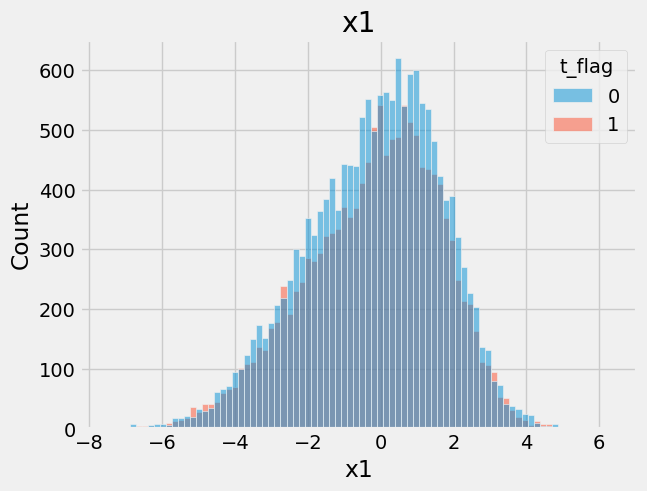

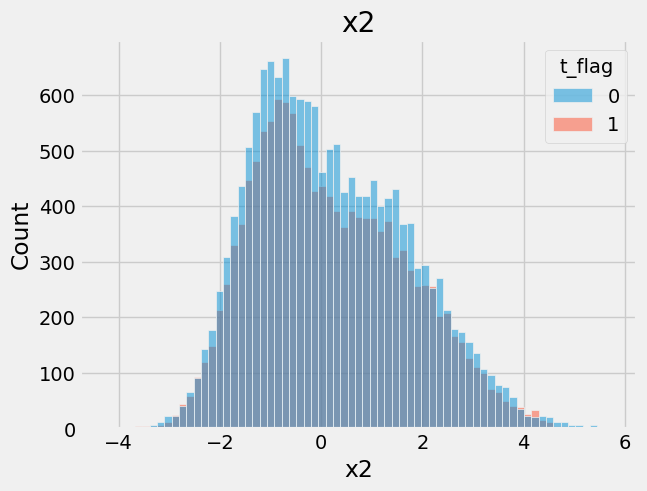

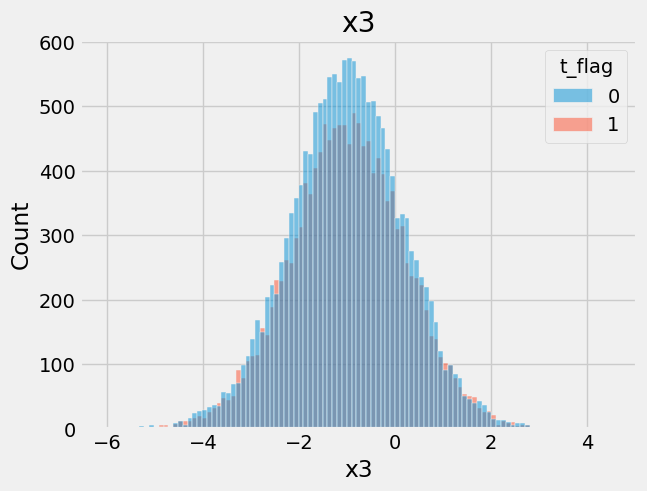

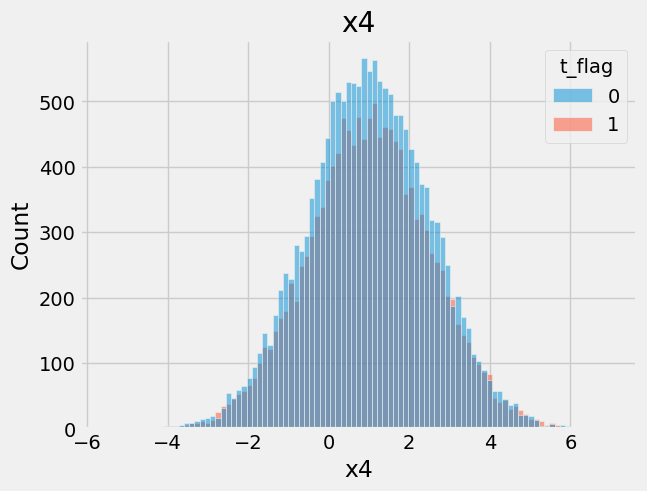

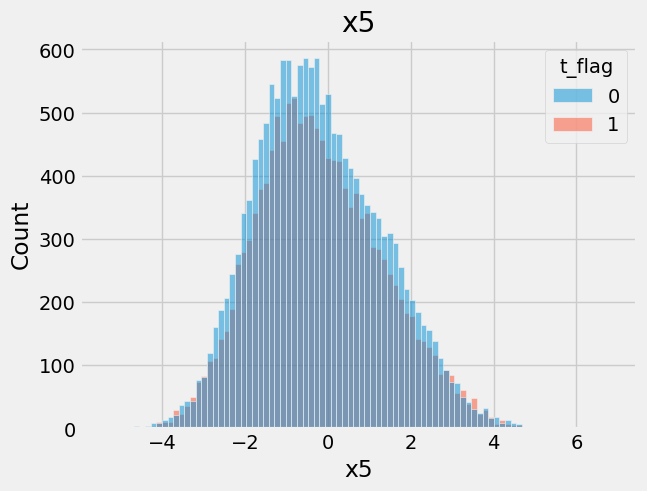

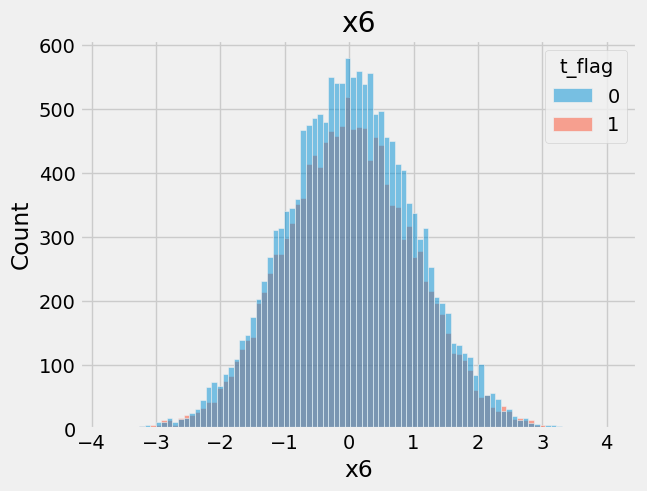

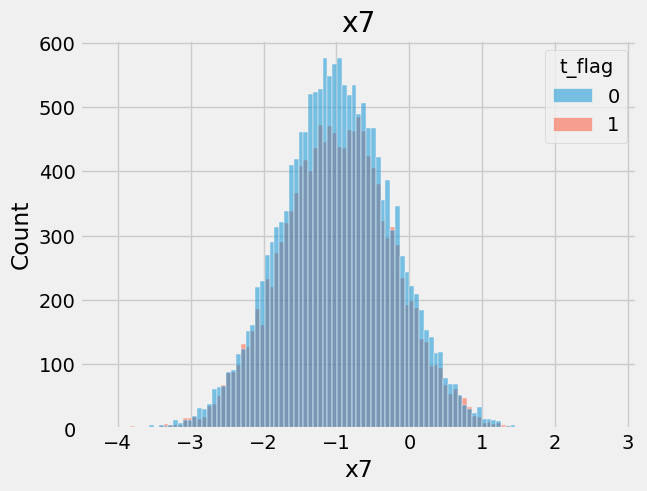

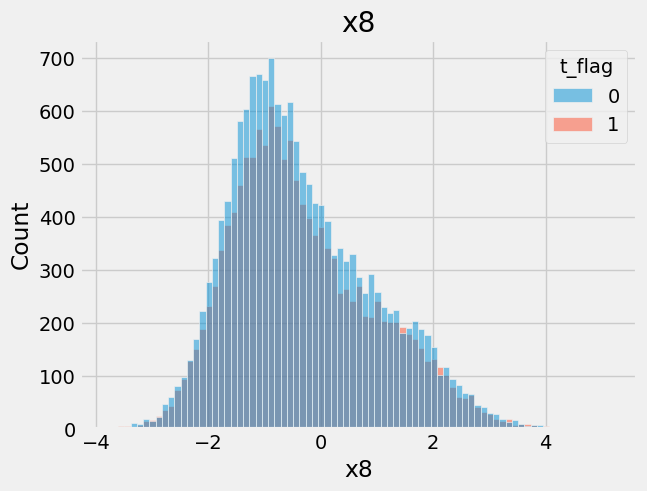

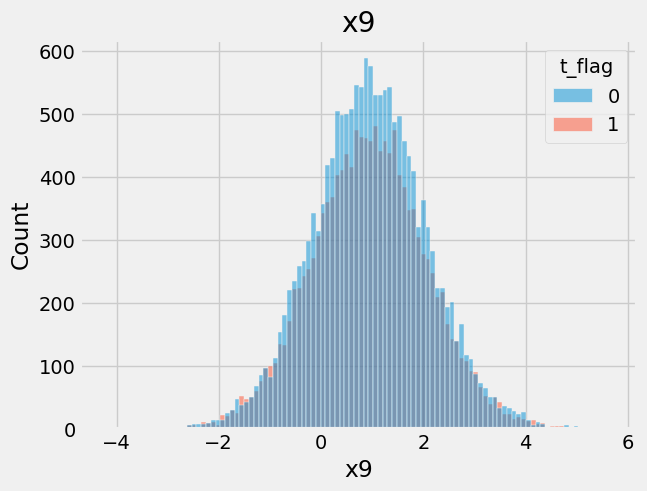

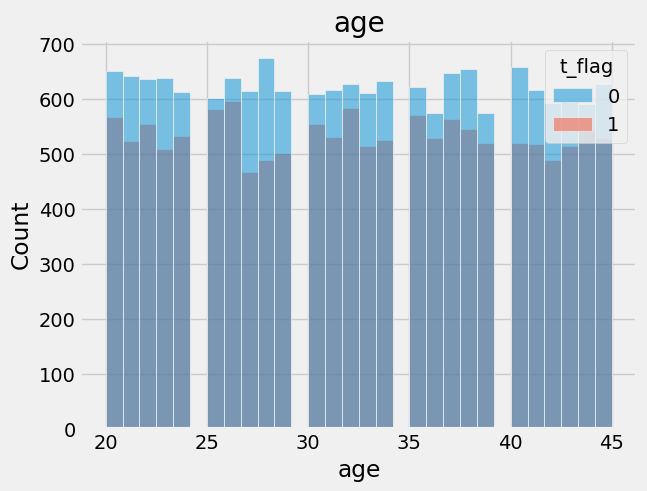

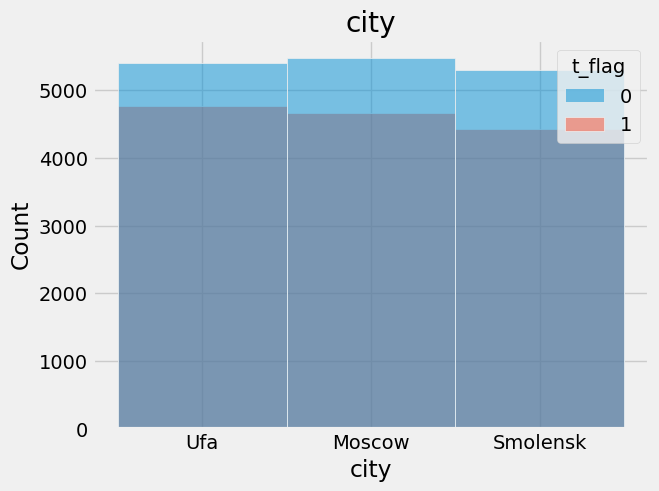

In [108]:
for col in col_df:
    sns.histplot(data = df_push, x=col, hue='t_flag').set_title(col)
    plt.show()

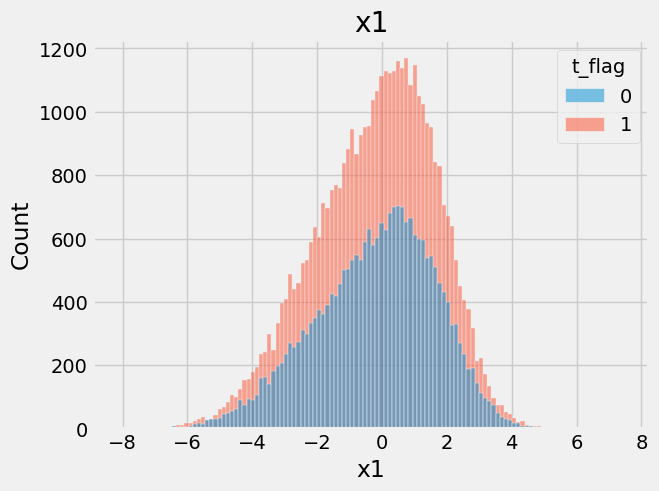

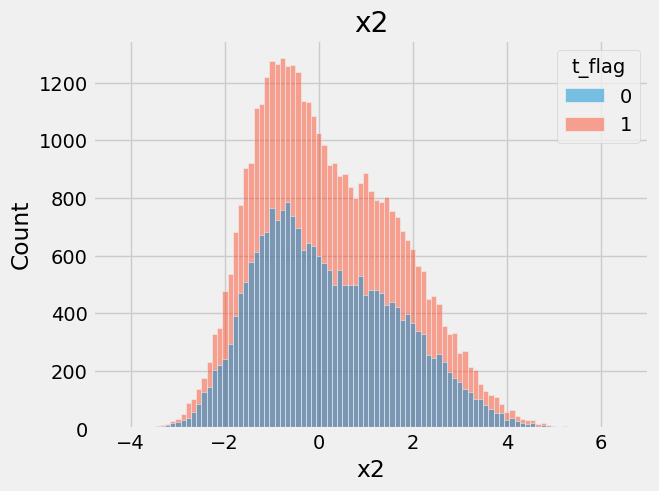

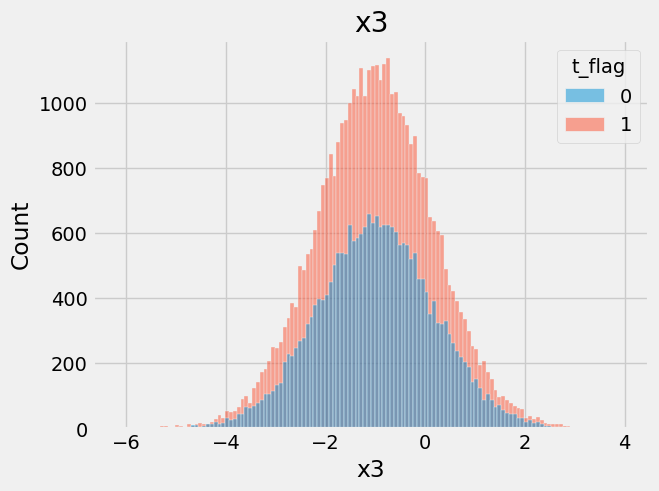

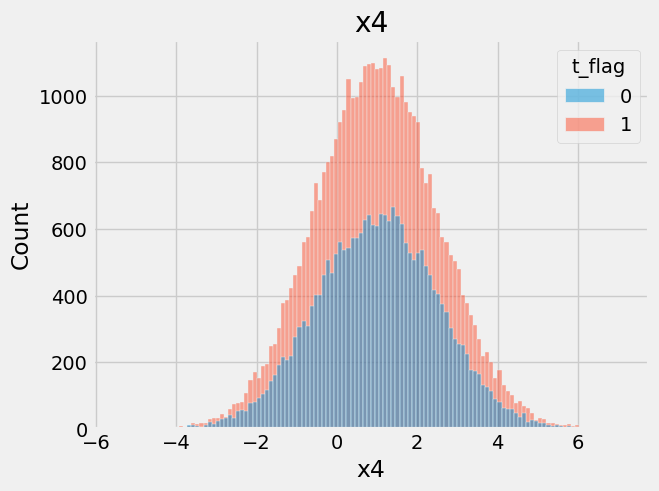

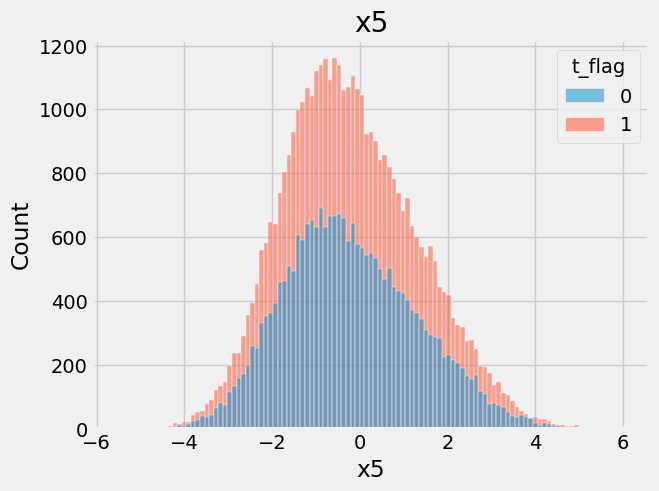

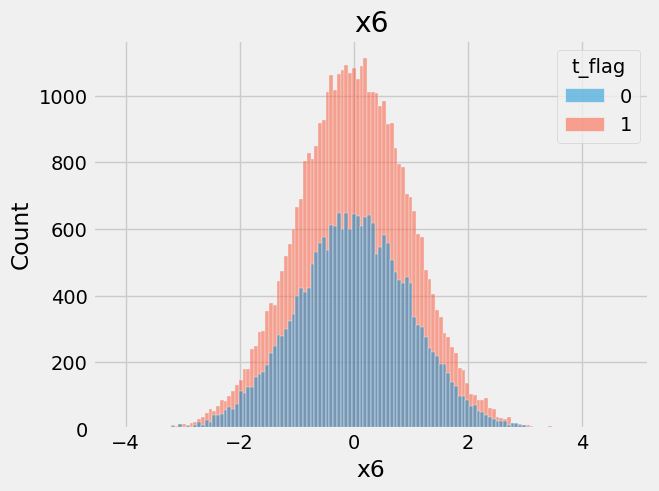

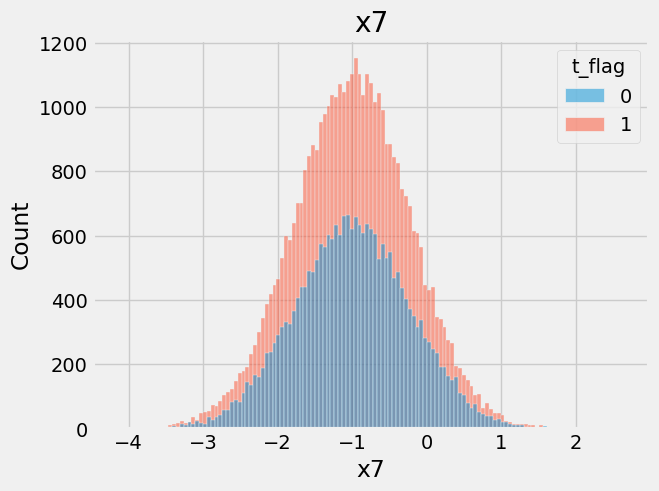

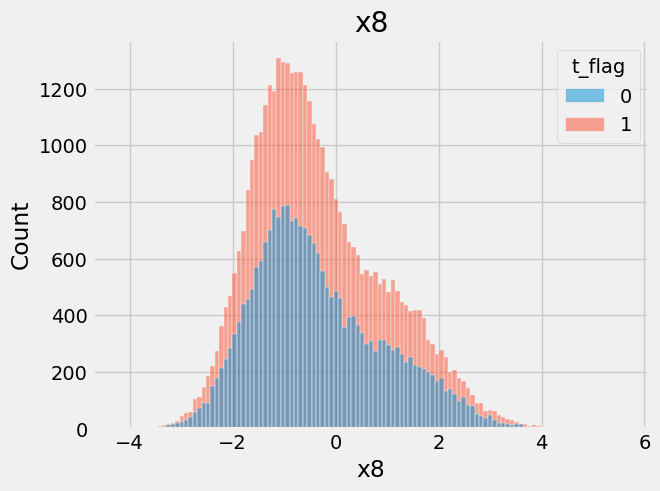

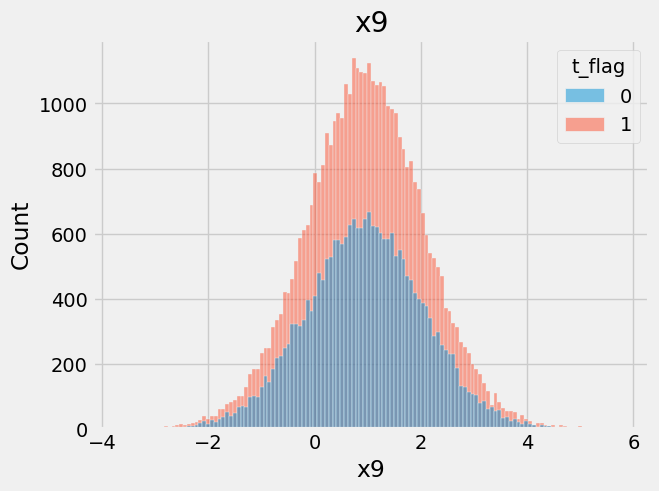

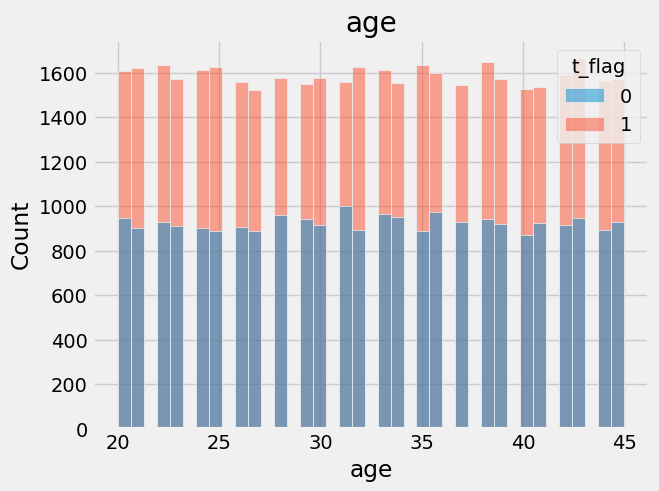

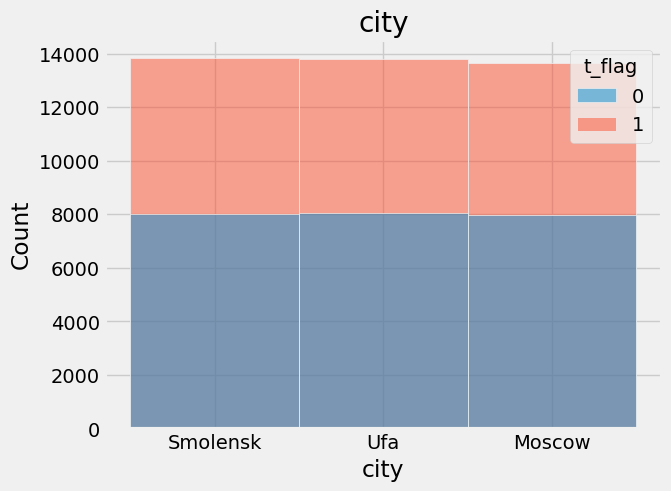

In [109]:
for col in col_df:
    sns.histplot(data = df_ban, x=col, hue='t_flag').set_title(col)
    plt.show()

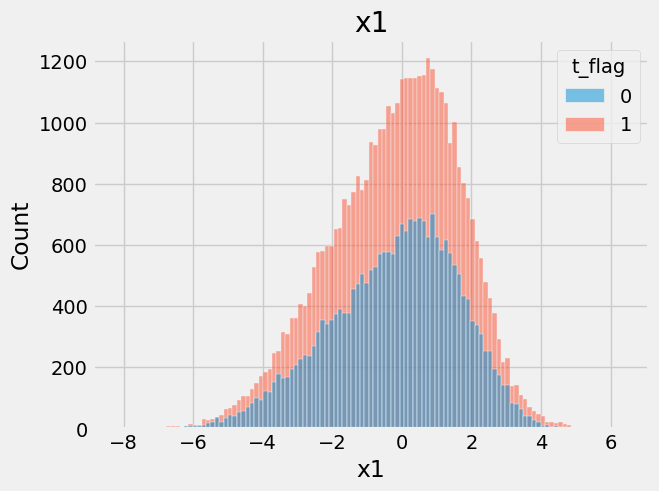

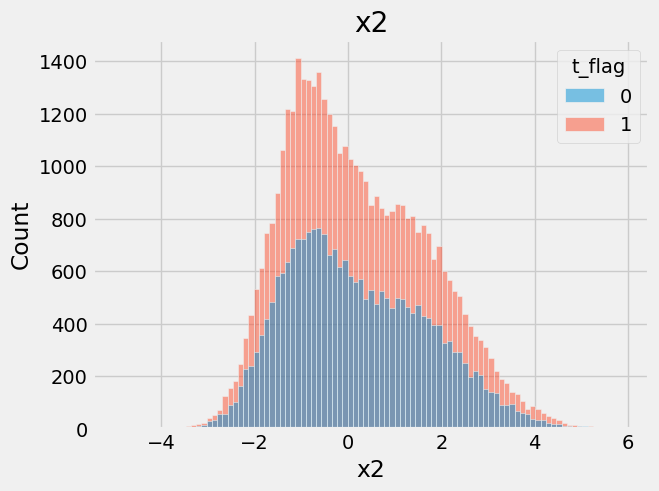

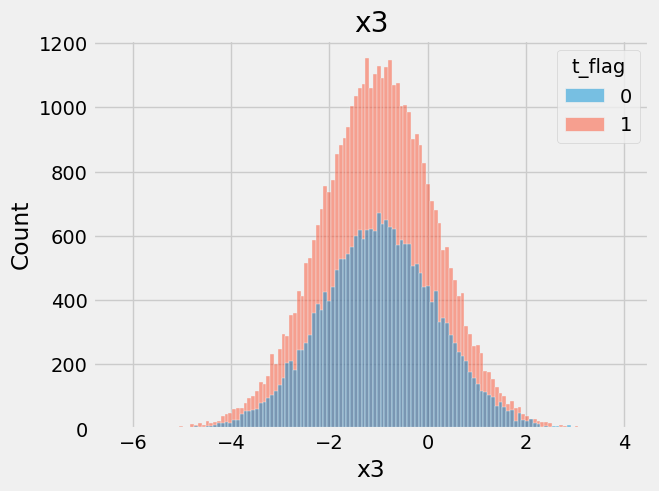

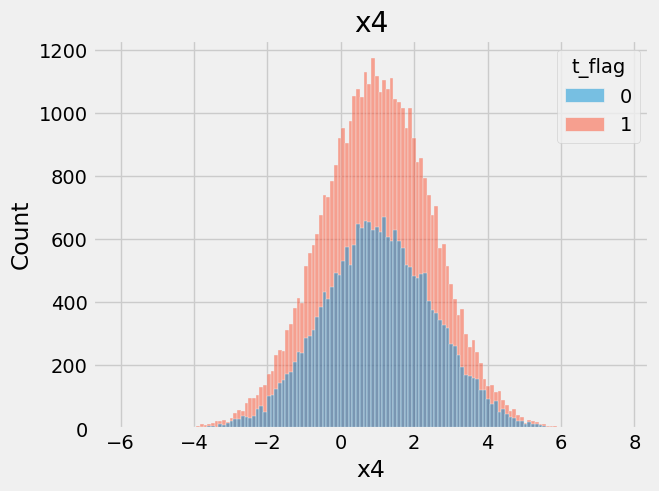

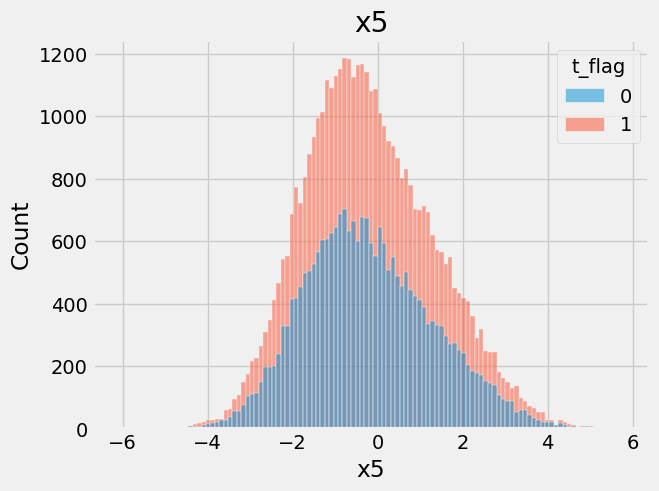

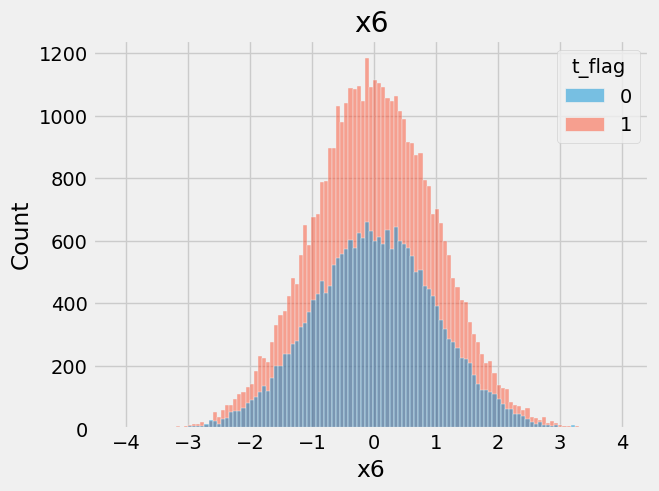

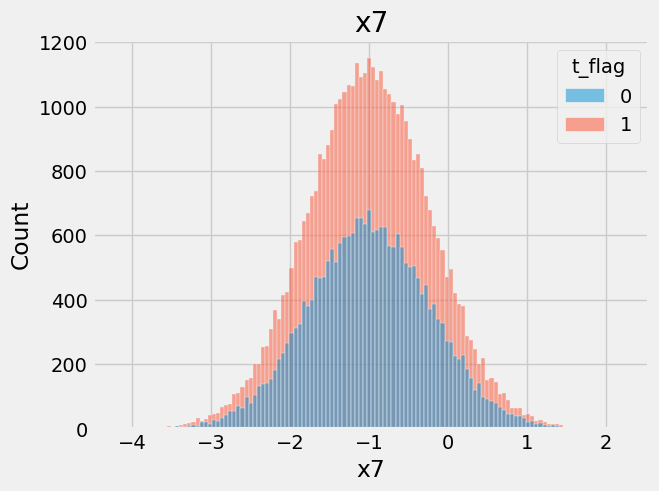

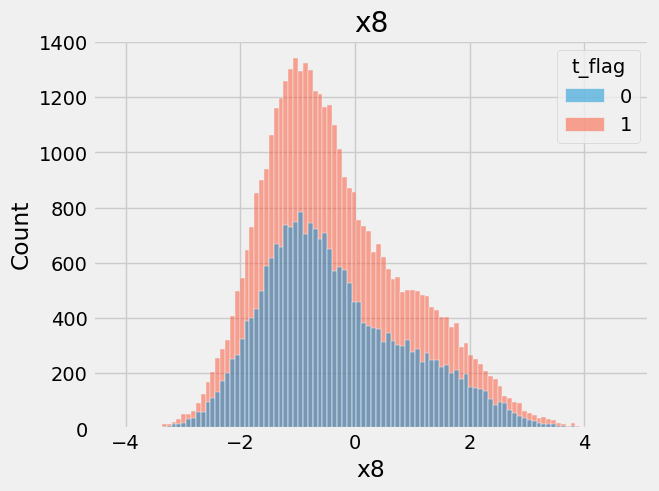

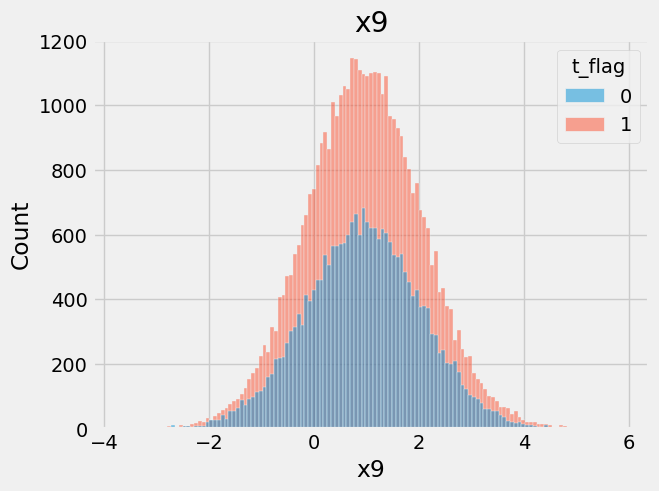

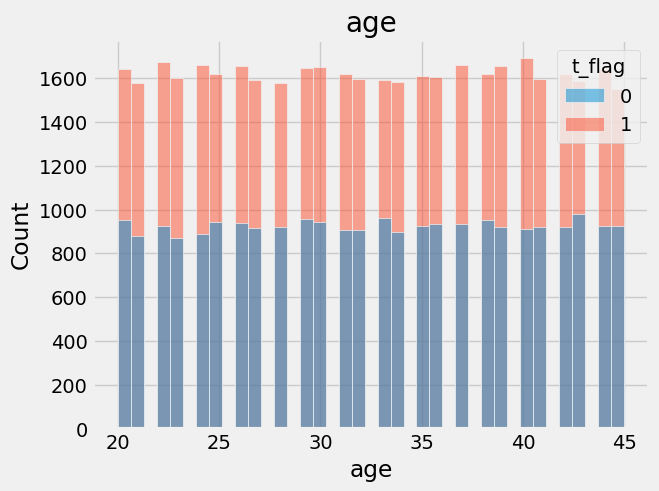

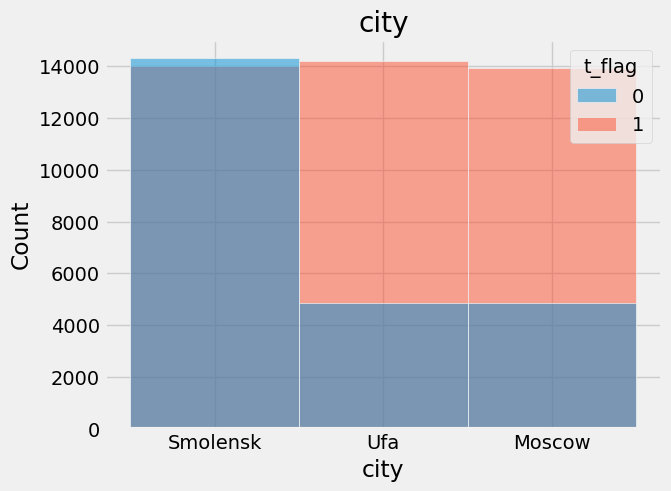

In [110]:
for col in col_df:
    sns.histplot(data = df_ads, x=col, hue='t_flag').set_title(col)
    plt.show()

In [ ]:
col_df.remove('city')

In [114]:
def print_psi(d):
    for col in col_df:
        psi = calculate_psi(expected = d[d.t_flag == 0][col],
                            actual = d[d.t_flag == 1][col])
        print(f'psi для признака {col} равно {psi}')

print('push:')
print_psi(df_push)

print('\nbanners:')
print_psi(df_ban)

print('\nother_ads:')
print_psi(df_ads)

push:
psi для признака x1 равно 0.0019976590705528966
psi для признака x2 равно 0.0012380892072832899
psi для признака x3 равно 0.0016827600971378314
psi для признака x4 равно 0.0009892398407578304
psi для признака x5 равно 0.002065895922248131
psi для признака x6 равно 0.0016063399896540883
psi для признака x7 равно 0.001930056540909934
psi для признака x8 равно 0.00042520607585143345
psi для признака x9 равно 0.0019400609828270229
psi для признака age равно 0.0021098994614910916

banners:
psi для признака x1 равно 0.00046662025831858663
psi для признака x2 равно 0.0003954600438791556
psi для признака x3 равно 0.00028738102702800025
psi для признака x4 равно 0.0008838676996653125
psi для признака x5 равно 0.0003158979991070901
psi для признака x6 равно 0.0004627019395682219
psi для признака x7 равно 0.0006987356175068499
psi для признака x8 равно 0.0004876221729152106
psi для признака x9 равно 0.00030781659001124806
psi для признака age равно 0.00043564774373922526

other_ads:
psi для

In [115]:
def calc_city(d):
    t1 = d[d['t_flag'] == 1][['city', 'target']]
    t0 = d[d['t_flag'] == 0][['city', 'target']]
    citys = list(d.city.unique())

    for c in citys:
        print(f'Для {c}: {round(t1[t1["city"] == c]["target"].mean() - t0[t0["city"] == c]["target"].mean(), 4)}')


print('push:')
calc_city(df_push)

print('\nbanners:')
calc_city(df_ban)

print('\nother_ads:')
calc_city(df_ads)


push:
Для Ufa: 0.8804
Для Moscow: 0.8779
Для Smolensk: 0.8745

banners:
Для Smolensk: 0.8805
Для Ufa: 0.8727
Для Moscow: 0.8758

other_ads:
Для Smolensk: 0.8599
Для Ufa: 0.8606
Для Moscow: 0.8542


### ваши выводы здесь:
Компания **push** - используем для моделирования:
- Контрольная и целевая группы имеют примерно одинаковое кол-во участников.
- Данные однородны.
- Значимой популяционной разницы между контрольной и целевой группами не обнаружено (PSI меньше 0.1).
- У всех городов высокий uplift.

Компания **banners** - не используем для моделирования:
- Целевая группа в 2 раза больше чем контрольная (из-за данного пункта).
- Данные однородны.
- Значимой популяционной разницы между контрольной и целевой группами не обнаружено (PSI меньше 0.1).
- У всех городов высокий uplift.

Компания **other_ads** - не используем для моделирования:
- Целевая группа в 2 раза больше чем контрольная.
- Очень много пользователей из Смоленска в контрольной группе, в сравнении с другими городами.
- Значимой популяционной разницы между контрольной и целевой группами не обнаружено (PSI меньше 0.1).
- У всех городов высокий uplift.

<h2> 3. Построение моделей и оценка их качества (14 баллов)</h2>

Постройте Uplift модели по собранным кампаниям, проведите тюнинг гиперпараметров и оцените их качество (qini score). Для каждой модели также постройте qini-curve.

**Комментарий по заданиям и оцениванию:**

* Реализован только подход Solomodel без дополнительных библиотек и калибровок  - **1 балл**

* Реализован Solomodel или Twomodel через Sklift или CausalML - **2 балла**

* Учтена калибровка Metalearner'ах - **2 балла**

* Корректно реализован ClassTransformation - **2 балла**

* Реализован UpliftRandomForest - **4 балла**

* Использованы пайплайны в Sklift - **2 балла**

* Реализован тюнинг ( Gridsearch \ Optuna ) - **1 балл**

In [122]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [157]:
citys = {'Ufa': 0, 'Moscow': 1, 'Smolensk': 2}
df_push['city'] = df_push['city'].apply(lambda x: citys[x])

In [158]:
df_push

,user_id,t_flag,report_dt,target,x1,x2,x3,x4,x5,x6,x7,x8,x9,age,city
0,113313,1,2025-01-31,1,-0.638977,-0.909261,0.371425,4.266304,0.046867,0.256346,-0.148376,-0.978289,-0.345443,22,0
1,112716,0,2025-01-31,0,1.475578,2.575684,-1.796922,0.337686,-1.842273,1.479767,-0.257879,-0.733646,1.690171,32,0
2,46553,1,2025-01-31,1,0.195649,-1.417551,-0.240279,2.383544,-0.770528,-0.179486,-1.416816,0.327576,0.252843,30,1
3,58613,1,2025-01-31,1,-0.546596,0.317454,-1.765601,1.619209,2.859905,0.265591,-0.765473,-1.143976,1.670653,45,0
4,3058,1,2025-01-31,1,1.737033,-1.793916,-0.298299,1.381068,-0.172993,0.227277,-0.682362,-0.674880,0.292995,35,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30034,23855,1,2025-01-31,0,-0.257454,1.143552,0.003656,1.773691,-1.477045,0.510814,-1.628702,-0.167182,0.028193,23,1
30035,157118,1,2025-01-31,1,0.922910,-0.911936,-0.364327,0.538011,1.295299,0.963438,-1.336433,-1.112280,0.367615,20,0
30036,73284,0,2025-01-31,0,-4.018258,0.600985,0.625325,1.935127,-0.598223,0.223394,-0.448312,-1.649982,-0.577729,35,0
30037,145245,0,2025-01-31,0,-1.613429,0.423633,-1.456553,-0.001634,-1.338179,-0.534171,-1.928229,0.212214,1.403401,24,1


In [223]:
#Реализован только подход Solomodel без дополнительных библиотек и калибровок

pipe = Pipeline(
    steps=[("log", LogisticRegression(random_state=42))]
)

X_train, X_test, y_train, y_test = train_test_split(df_push.drop(columns = ['target', 'report_dt', 'user_id']),
                                                    df_push.target,
                                                    test_size=0.25,
                                                    random_state=42,
                                                    stratify=df_push.target)

pipe.fit(X_train, y_train)

X_test_0 = X_test.copy()
X_test_0['t_flag'] = 0
y_pred_0 = pipe.predict_proba(X_test_0)[:,1]

X_test_1 = X_test.copy()
X_test_1['t_flag'] = 1
y_pred_1 = pipe.predict_proba(X_test_1)[:,1]

uplift_0 = y_pred_1 - y_pred_0


In [160]:
uplift_0

array([0.86839894, 0.87540704, 0.89105391, ..., 0.87345521, 0.87867079,
       0.88675454])

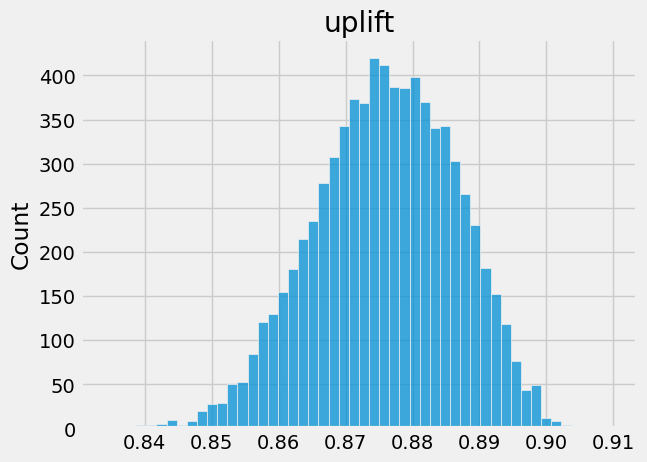

In [163]:
uplift_pd = pd.DataFrame(data = uplift_0, index = X_test.index, columns=['uplift'])
uplift_pd = uplift_pd.sort_values(by='uplift', ascending=False)
sns.histplot(data = uplift_pd, x=uplift_0).set_title('uplift')
plt.show()

In [174]:
qini_auc_score(y_true=y_test,
               uplift=pd.Series(uplift_0, index=X_test.index),
               treatment=X_test['t_flag'])

0.02702308623041384

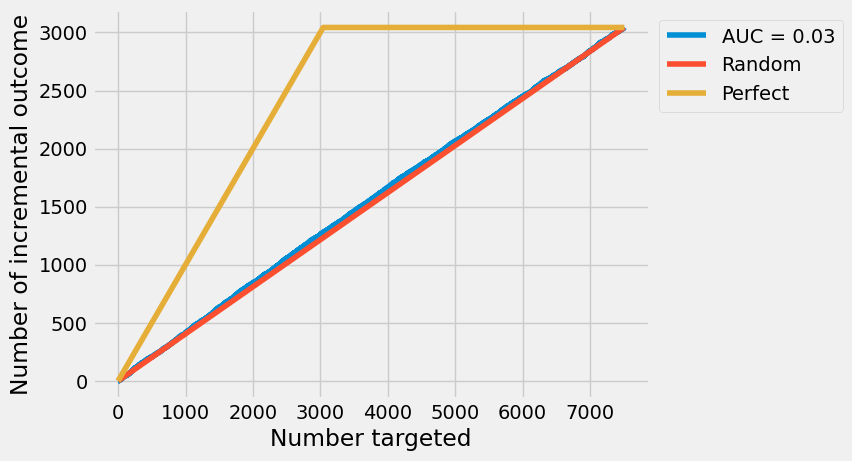

In [172]:
plot_qini_curve(y_true=y_test,
                  uplift=pd.Series(uplift_0, index=X_test.index),
                  treatment=X_test['t_flag'])
plt.show()

In [234]:
#Реализован Solomodel или Twomodel через Sklift или CausalML
sm = SoloModel(estimator=LogisticRegression(random_state=42), method='treatment_interaction')

sm.fit(X_train.drop(columns='t_flag'),
       y_train,
       treatment=X_train['t_flag'])

uplift_1 = sm.predict(X_test.drop(columns='t_flag'))

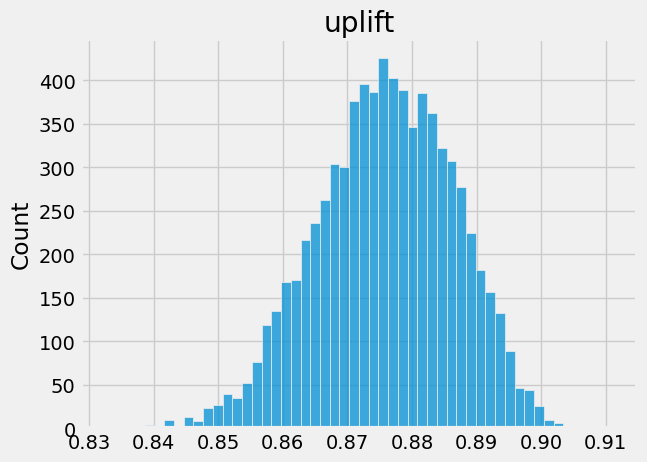

In [235]:
uplift_pd = pd.DataFrame(data = uplift_1, index = X_test.index, columns=['uplift'])
uplift_pd = uplift_pd.sort_values(by='uplift', ascending=False)
sns.histplot(data = uplift_pd, x=uplift_0).set_title('uplift')
plt.show()

In [236]:
qini_auc_score(y_true=y_test,
               uplift=pd.Series(uplift_1, index=X_test.index),
               treatment=X_test['t_flag'])

0.027710494773039312

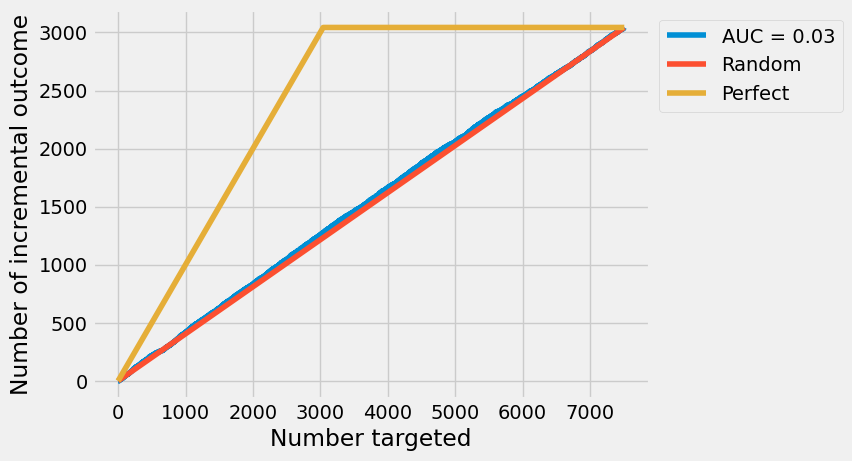

In [237]:
plot_qini_curve(y_true=y_test,
                  uplift=pd.Series(uplift_1, index=X_test.index),
                  treatment=X_test['t_flag'])
plt.show()

In [180]:
#Использованы пайплайны в Sklift
pipe = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('model_uplift', sm)
])
pipe.fit(X_train.drop(columns='t_flag'),
         y_train,
         model_uplift__treatment=X_train['t_flag'])
uplift_2 = pipe.predict(X_test.drop(columns='t_flag'))

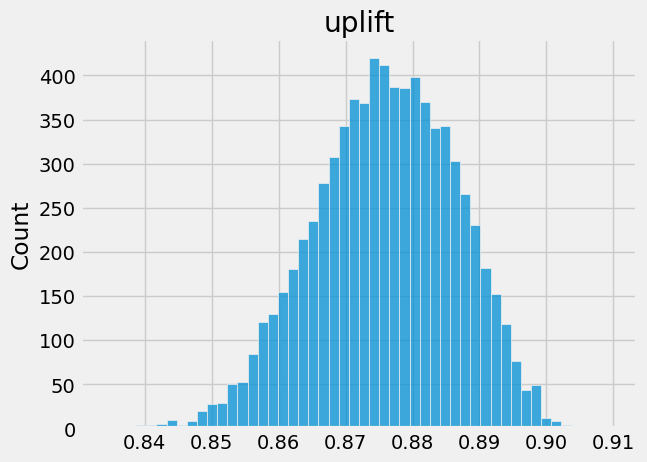

In [181]:
uplift_pd = pd.DataFrame(data = uplift_2, index = X_test.index, columns=['uplift'])
uplift_pd = uplift_pd.sort_values(by='uplift', ascending=False)
sns.histplot(data = uplift_pd, x=uplift_0).set_title('uplift')
plt.show()

In [182]:
qini_auc_score(y_true=y_test,
               uplift=pd.Series(uplift_2, index=X_test.index),
               treatment=X_test['t_flag'])

0.027048834624026737

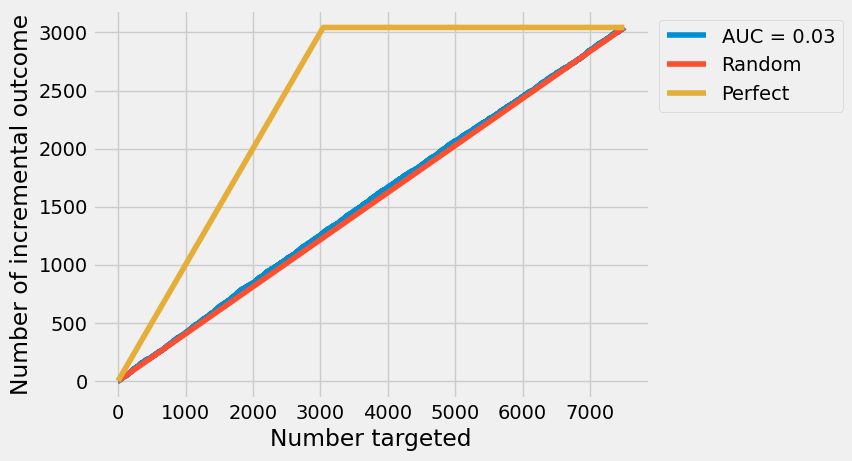

In [183]:
plot_qini_curve(y_true=y_test,
                  uplift=pd.Series(uplift_2, index=X_test.index),
                  treatment=X_test['t_flag'])
plt.show()

In [268]:
#реализован ClassTransformation

model_1_cb = CatBoostClassifier(verbose=0, thread_count=-1, depth=8, iterations=5, learning_rate=0.1)

ct = ClassTransformation(model_1_cb)

ct = ct.fit(X_train.drop(columns=['t_flag']), y_train, X_train['t_flag'])
uplift_ct = ct.predict(X_test.drop(columns='t_flag'))

In [269]:
qini_auc_score(y_true=y_test,
                 uplift=uplift_ct,
                 treatment=X_test['t_flag'])

0.0215980468298541

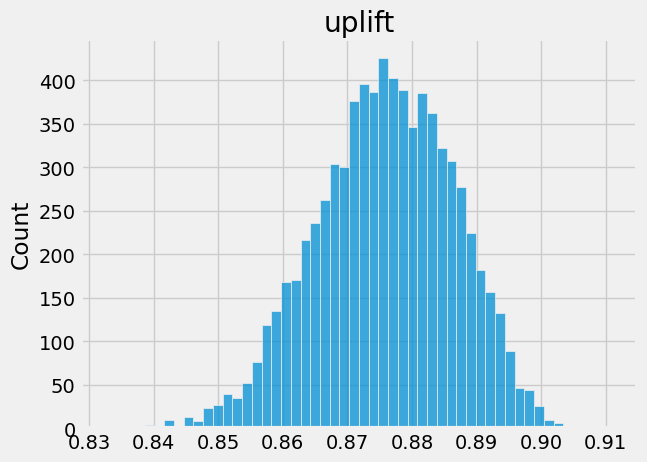

In [270]:
uplift_pd = pd.DataFrame(data = uplift_ct, index = X_test.index, columns=['uplift'])
uplift_pd = uplift_pd.sort_values(by='uplift', ascending=False)
sns.histplot(data = uplift_pd, x=uplift_0).set_title('uplift')
plt.show()

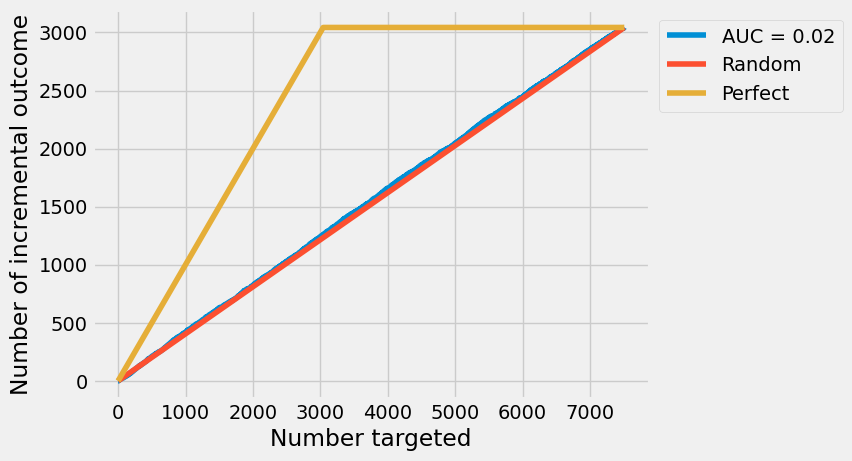

In [271]:
plot_qini_curve(y_true=y_test,
                  uplift=pd.Series(uplift_ct, index=X_test.index),
                  treatment=X_test['t_flag'])
plt.show()

In [ ]:
#Реализован UpliftRandomForest
X_train_1 = X_train.copy()
X_test_1 = X_test.copy()

X_train_1['t_flag'] = X_train_1['t_flag'].astype('str')
X_test_1['t_flag'] = X_test_1['t_flag'].astype('str')

uplift_forest = UpliftRandomForestClassifier(control_name='0', )

uplift_forest.fit(X=X_train_1.drop(columns='t_flag').values,
                  y=y_train.values,
                  treatment=X_train_1['t_flag'].values)

uplift_fr = uplift_forest.predict(X=X_test_1.drop(columns='t_flag').values)

In [230]:
uplift_forest.predict(X=X_test_1.drop(columns='t_flag').values)

array([[0.87678137],
       [0.87678137],
       [0.87678137],
       ...,
       [0.87678137],
       [0.87678137],
       [0.87678137]])

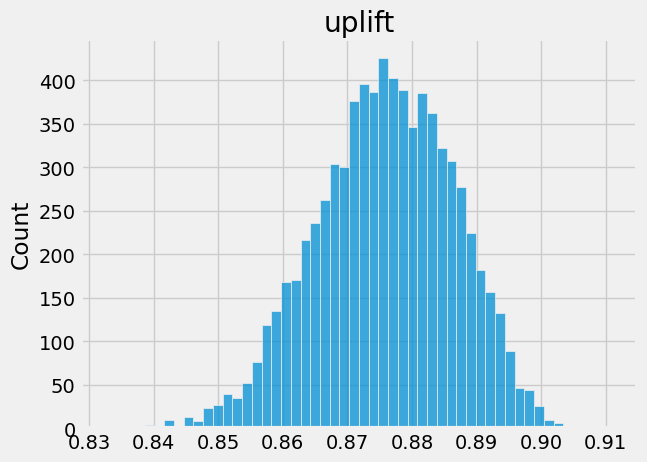

In [231]:
uplift_pd = pd.DataFrame(data = uplift_fr, index = X_test.index, columns=['uplift'])
uplift_pd = uplift_pd.sort_values(by='uplift', ascending=False)
sns.histplot(data = uplift_pd, x=uplift_0).set_title('uplift')
plt.show()

In [232]:
qini_auc_score(y_true=y_test,
                 uplift=uplift_fr.reshape(-1),
                 treatment=X_test_1['t_flag'].astype('int'))

0.0

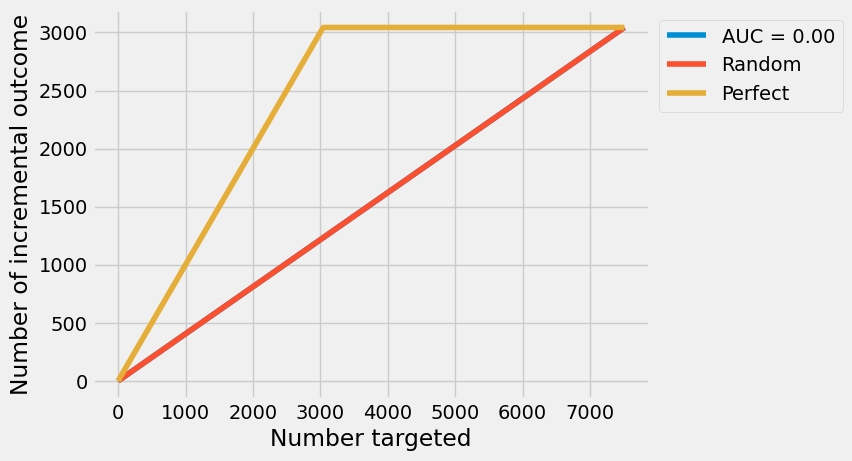

In [233]:
plot_qini_curve(y_true=y_test,
                  uplift=pd.Series(uplift_fr.reshape(-1), index=X_test_1.index),
                  treatment=X_test_1['t_flag'].astype(int))
plt.show()

<h2>4. Подготовка ответа в требуемом формате и подготовка выводов (6 баллов)</h2>

a) Сделайте скоринг нужных клиентов, подготовьте ответ в требуемом формате

б) Сделайте краткую аналитику того, какой канал взаимодействия наиболее предпочтителен

в) Сделайте выводы по проделанной работе

**Комментарий по заданиям и оцениванию:**

* Подготовлен только ответ - **1 балл**
* Подготовлен содержательный вывод по проделанной работе - **4 балла**
* Корректно принято решение об отправке/не отправке коммуникации клиентам в зависимости от значений Uplift - **1 балл**

### ваши выводы здесь